# Cleaning anomalies in time series per region slug



## Load  libraries

In [ ]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

In [ ]:
#import pandas as pd  
#import datetime 
#dates = pd.Series(['2010-11-01','2010-11-02','2010-11-03',
#               '2010-12-24', '2010-12-25', '2010-12-26', 
#               '2010-12-27', '2010-12-28', '2010-12-29', 
#               '2010-12-30', '2011-01-01', '2011-01-02'])

#### Run single

In [37]:
from src.runners.clean import _run_single 

2021-05-18 10:56:47.974 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_mexico...

2021-05-18 10:56:47.975 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_mexico')
        
2021-05-18 10:56:49.630 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0694676769115674
2021-05-18 10:56:49.656 | DEBUG    | src.runners.clean:_c_param:361 - C max: 21.389353538231347
2021-05-18 10:56:49.660 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 10:56:49.661 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 10:56:49.662 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 10:56:49.663 | DEBUG    | src.runners.clean:_valida

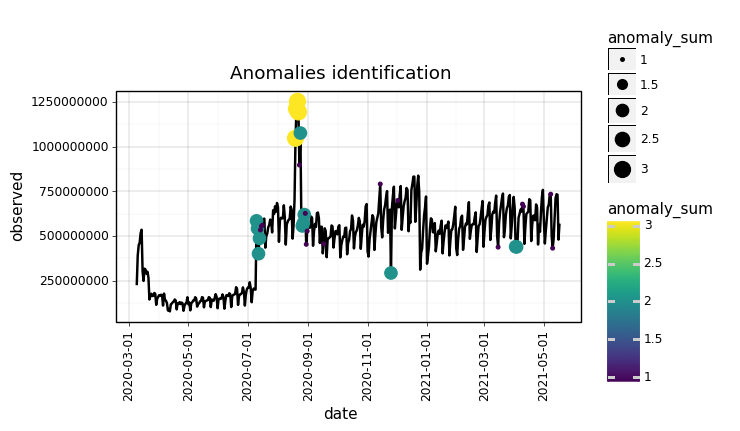

2021-05-18 10:56:50.292 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...


<ggplot: (8744465294053)>


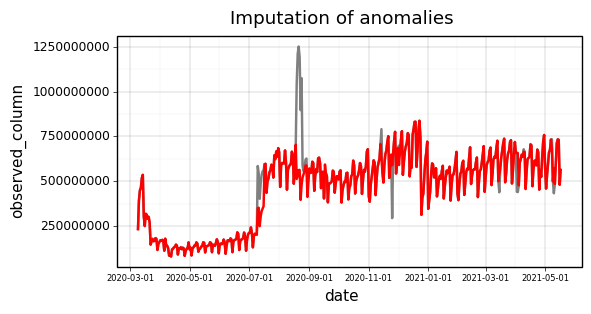

2021-05-18 10:56:50.681 | INFO     | src.runners.clean:_run_step:782 - Output variable S1_shift
2021-05-18 10:56:50.682 | DEBUG    | src.runners.clean:_shift_level:546 - 

2021-05-18 10:56:50.682 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 10:56:50.684 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 10:56:50.690 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 10:56:50.690 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 21.389353538231347


<ggplot: (8744464638745)>


2021-05-18 10:56:51.243 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 10:56:51.486 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at 2020-07-15 00:00:00
2021-05-18 10:56:51.490 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 10:56:51.491 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: -202904125.59892994
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/s

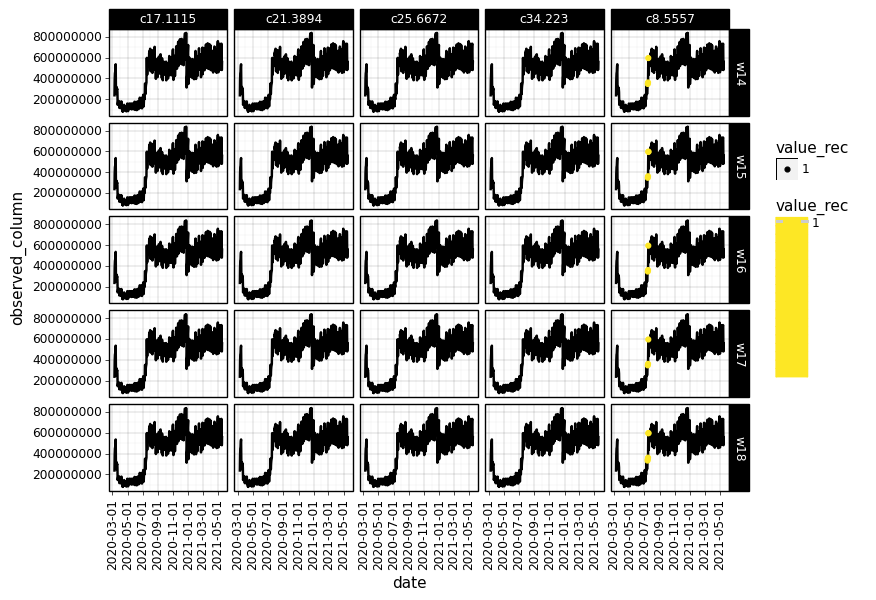

<ggplot: (8744463016253)>


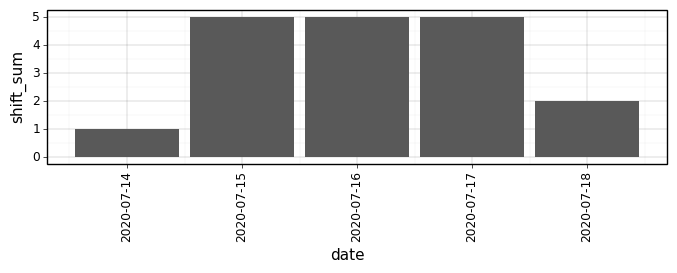

<ggplot: (8744459590405)>


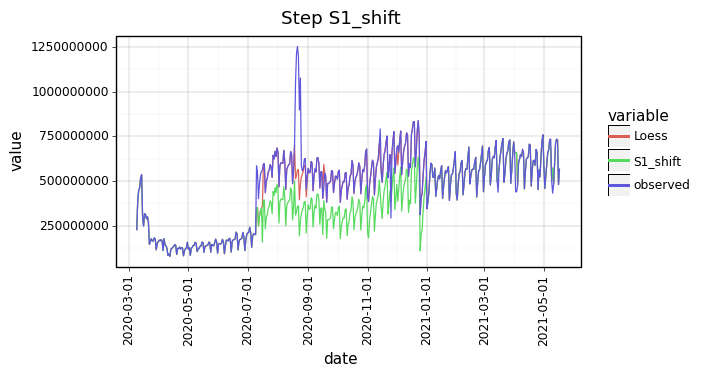

2021-05-18 10:57:06.837 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 10:57:06.842 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 10:57:06.843 | INFO     | src.runners.clean:_run_step:763 - Target variable: S1_shift 

2021-05-18 10:57:06.844 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 10:57:06.844 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-18 10:57:06.850 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 10:57:06.850 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to 

<ggplot: (8744475887633)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 423 rows containing missing values.


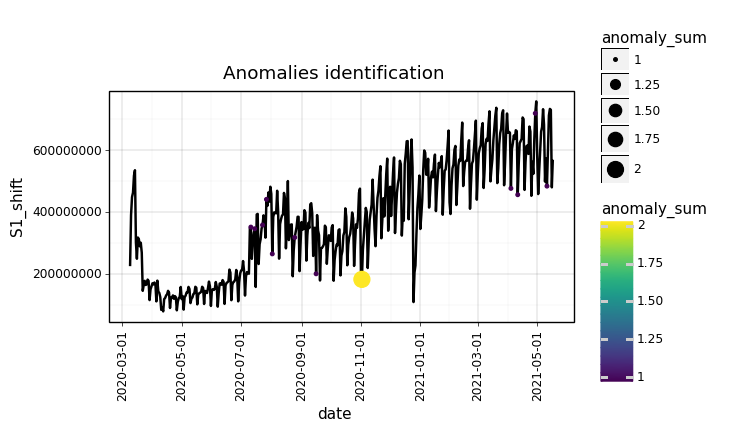

2021-05-18 10:57:08.844 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...


<ggplot: (8744458855909)>


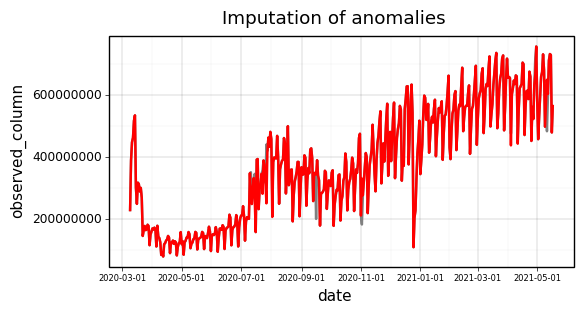

2021-05-18 10:57:09.395 | INFO     | src.runners.clean:_run_step:782 - Output variable S2_shift
2021-05-18 10:57:09.398 | DEBUG    | src.runners.clean:_shift_level:546 - 

2021-05-18 10:57:09.400 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 10:57:09.403 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 10:57:09.409 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 10:57:09.411 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 21.389353538231347


<ggplot: (8744458889977)>


2021-05-18 10:57:10.014 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 10:57:10.251 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 10:57:10.254 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 10:57:10.256 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: could not convert string to float: '#7F7F7F'

In [59]:
daily, weekly = _run_single(region_slug='country_mexico', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            c_metric = 'max', 
                            f_metric = 20, 
                            print_report = True, 
                            print_plot = True)

In [39]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

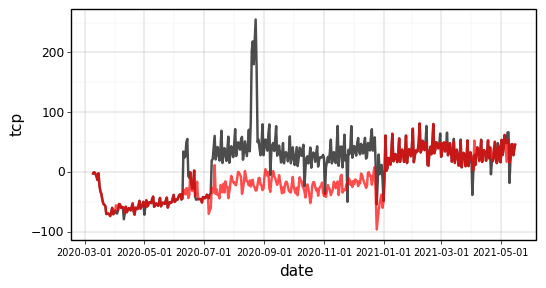

<ggplot: (8744462152793)>

In [40]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red', size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

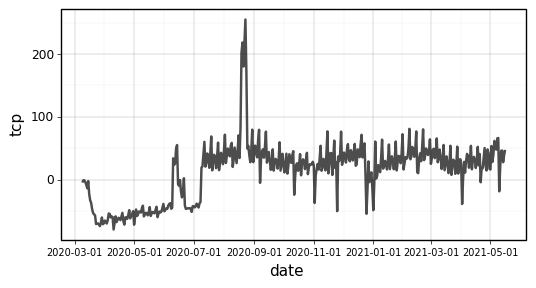

<ggplot: (8744467104457)>

In [41]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

In [ ]:
weekly.head(3)
gg = (p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
gg

In [ ]:
print(daily.date.min())
print(daily.date.max())
print(weekly.week.max())

#### Run by batch

In [60]:
from src.runners.clean import _run_batch 

In [62]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona", 
          c_metric = 'max', 
          f_metric = 4)

2021-05-18 12:36:24.028 | INFO     | src.runners.clean:_run_batch:898 - TO DO regions  81
2021-05-18 12:36:24.028 | INFO     | src.runners.clean:_run_single:828 - ... here we go aguascalientes...

2021-05-18 12:36:24.031 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-05-18 12:36:25.560 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0273899198125596
2021-05-18 12:36:25.588 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.109559679250238
2021-05-18 12:36:25.591 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:25.592 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:25.592 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:25.594 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:25.600 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:36:25.600 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

arequipa


2021-05-18 12:36:32.620 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3707797834677795
2021-05-18 12:36:32.639 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.483119133871118
2021-05-18 12:36:32.643 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:32.643 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:32.644 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:32.645 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:32.650 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:36:32.651 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:36:33.801 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.483119133871118
2021-05-18 12:36:34.365 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:36:34.603 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:36:34.607 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:36:34.608 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:36:

barranquilla


2021-05-18 12:36:37.858 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.76668667025904
2021-05-18 12:36:37.879 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.06674668103616
2021-05-18 12:36:37.883 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:37.883 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:37.884 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:37.885 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:37.890 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.76668667025904
2021-05-18 12:36:37.891 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.76668667025904
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:36:39.868 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:36:40.047 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_barranquilla.pdf
2021-05-18 12:36:41.372 | INFO     | src.runner

belem


2021-05-18 12:36:42.859 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.6751306885065211
2021-05-18 12:36:42.878 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.7005227540260845
2021-05-18 12:36:42.881 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:42.882 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:42.883 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:42.884 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:42.889 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:36:42.891 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:36:45.039 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_belem.pdf
2021-05-18 12:36:46.432 | INFO     | src.runners.clean:_run_single:881 - ... belem done ...

2021-05-18 12:36:46.433 | INFO     | src.runners.clean:_run_single:828 - ... here we go belohorizonte...

2021-05-18 12:36:46.434 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('belohorizonte')
        


belohorizonte


2021-05-18 12:36:49.030 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7932268803995419
2021-05-18 12:36:49.050 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.1729075215981677
2021-05-18 12:36:49.053 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:49.054 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:49.056 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:49.058 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:49.063 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:36:49.063 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:36:52.534 | INFO     | src.runners.clean:_run_single:881 - ... belohorizonte done ...

2021-05-18 12:36:52.536 | INFO     | src.runners.clean:_run_single:828 - ... here we go bogota...

2021-05-18 12:36:52.538 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('bogota')
        


bogota


2021-05-18 12:36:55.239 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.7885534354346917
2021-05-18 12:36:55.256 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.154213741738767
2021-05-18 12:36:55.259 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:36:55.260 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:36:55.260 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:36:55.262 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:36:55.267 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7885534354346917
2021-05-18 12:36:55.267 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.7885534354346917
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

brasilia


2021-05-18 12:37:01.556 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.045577611833902
2021-05-18 12:37:01.577 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.182310447335608
2021-05-18 12:37:01.580 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:01.581 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:01.583 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:01.584 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:01.589 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:01.589 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_brasilia.pdf
2021-05-18 12:37:06.839 | INFO     | src.runners.clean:_run_single:881 - ... brasilia done ...

2021-05-18 12:37:06.840 | INFO     | src.runners.clean:_run_single:828 - ... here we go bucaramanga...

2021-05-18 12:37:06.842 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('bucaramanga')
        


bucaramanga


2021-05-18 12:37:08.293 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6872269818077374
2021-05-18 12:37:08.315 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.74890792723095
2021-05-18 12:37:08.319 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:08.319 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:08.320 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:08.321 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:08.327 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6872269818077374
2021-05-18 12:37:08.327 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6872269818077374
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-05-18 12:37:10.508 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_bucaramanga.pdf
2021-05-18 12:37:11.831 | INFO     | src.runners.clean:_run_single:881 - ... bucaramanga done ...

2021-05-18 12:37:11.833 | INFO     | src.runners.clean:_run_single:828 - ... here we go buenosaires...

2021-05-18 12:37:11.834 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('buenosaires')
        


buenosaires


2021-05-18 12:37:16.963 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.9098498045084976
2021-05-18 12:37:16.982 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.6393992180339905
2021-05-18 12:37:16.986 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:16.986 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:16.987 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:16.988 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:16.994 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:16.995 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:37:19.163 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_buenosaires.pdf
2021-05-18 12:37:20.547 | INFO     | src.runners.clean:_run_single:881 - ... buenosaires done ...

2021-05-18 12:37:20.549 | INFO     | src.runners.clean:_run_single:828 - ... here we go cali...

2021-05-18 12:37:20.550 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('cali')
        


cali


2021-05-18 12:37:22.056 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4587580136087392
2021-05-18 12:37:22.074 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.835032054434957
2021-05-18 12:37:22.078 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:22.078 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:22.080 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:22.081 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:22.087 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:22.087 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_cali.pdf
2021-05-18 12:37:25.621 | INFO     | src.runners.clean:_run_single:881 - ... cali done ...

2021-05-18 12:37:25.622 | INFO     | src.runners.clean:_run_single:828 - ... here we go campinas...

2021-05-18 12:37:25.625 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('campinas')
        


campinas


2021-05-18 12:37:27.359 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.8807937888708207
2021-05-18 12:37:27.379 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.523175155483283
2021-05-18 12:37:27.383 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:27.384 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:27.384 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:27.385 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:27.391 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:27.392 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:37:29.554 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_campinas.pdf
2021-05-18 12:37:30.881 | INFO     | src.runners.clean:_run_single:881 - ... campinas done ...

2021-05-18 12:37:30.882 | INFO     | src.runners.clean:_run_single:828 - ... here we go cartagena...

2021-05-18 12:37:30.883 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('cartagena')
        


cartagena


2021-05-18 12:37:33.567 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.5510305787633392
2021-05-18 12:37:33.591 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.204122315053357
2021-05-18 12:37:33.594 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:33.595 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:33.595 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:33.597 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:33.602 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5510305787633392
2021-05-18 12:37:33.602 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5510305787633392
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:37:35.757 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_cartagena.pdf
2021-05-18 12:37:37.315 | INFO     | src.runners.clean:_run_single:881 - ... cartagena done ...

2021-05-18 12:37:37.317 | INFO     | src.runners.clean:_run_single:828 - ... here we go cordoba...

2021-05-18 12:37:37.318 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('cordoba')
        


cordoba


2021-05-18 12:37:38.915 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6189154013154357
2021-05-18 12:37:38.938 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.475661605261743
2021-05-18 12:37:38.941 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:38.942 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:38.942 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:38.944 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:38.950 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6189154013154357
2021-05-18 12:37:38.950 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6189154013154357
2021-05-18 12:37:38.973 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

country_argentina


2021-05-18 12:37:45.154 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.2809406370453256
2021-05-18 12:37:45.172 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.123762548181302
2021-05-18 12:37:45.176 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:45.176 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:45.177 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:45.178 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:45.184 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:45.185 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
2021-05-18 12:37:45.208 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

country_barbados


2021-05-18 12:37:50.159 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.9579304881178845
2021-05-18 12:37:50.191 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.831721952471538
2021-05-18 12:37:50.194 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:50.195 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:50.195 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:50.197 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:50.203 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.9579304881178845
2021-05-18 12:37:50.203 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.9579304881178845
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

country_brazil


2021-05-18 12:37:57.559 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:37:57.575 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:37:57.579 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:37:57.579 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:37:57.580 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:37:57.580 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:37:57.586 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:37:57.587 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:37:59.741 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_brazil.pdf
2021-05-18 12:38:01.357 | INFO     | src.runners.clean:_run_single:881 - ... country_brazil done ...

2021-05-18 12:38:01.359 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_chile...

2021-05-18 12:38:01.361 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_chile')
        


country_chile


2021-05-18 12:38:03.382 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.142744523852838
2021-05-18 12:38:03.411 | DEBUG    | src.runners.clean:_c_param:361 - C max: 16.570978095411352
2021-05-18 12:38:03.415 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:03.416 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:03.416 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:03.418 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:03.422 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-18 12:38:03.424 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

country_colombia


2021-05-18 12:38:09.607 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.691574492443756
2021-05-18 12:38:09.628 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.766297969775024
2021-05-18 12:38:09.631 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:09.632 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:09.635 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:09.635 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:09.639 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.691574492443756
2021-05-18 12:38:09.640 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.691574492443756
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

2021-05-18 12:38:13.370 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_costa_rica')
        


country_costa_rica


2021-05-18 12:38:15.795 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6067585208477897
2021-05-18 12:38:15.822 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.427034083391159
2021-05-18 12:38:15.825 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:15.826 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:15.827 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:15.828 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:15.835 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6067585208477897
2021-05-18 12:38:15.835 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6067585208477897
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:38:19.345 | INFO     | src.runners.clean:_run_single:881 - ... country_costa_rica done ...

2021-05-18 12:38:19.347 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_dominican_republic...

2021-05-18 12:38:19.349 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_dominican_republic')
        


country_dominican_republic


2021-05-18 12:38:20.803 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3351452315716383
2021-05-18 12:38:20.824 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.340580926286553
2021-05-18 12:38:20.828 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:20.828 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:20.829 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:20.830 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:20.835 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:38:20.835 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:38:21.975 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 12:38:21.980 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 12:38:21.980 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.340580926286553
2021-05-18 12:38:22.535 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:38:22.772 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:38:22.775 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:38:22.777 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value i

country_ecuador


2021-05-18 12:38:26.760 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.0178491790094
2021-05-18 12:38:26.779 | DEBUG    | src.runners.clean:_c_param:361 - C max: 8.0713967160376
2021-05-18 12:38:26.783 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:26.783 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:26.785 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:26.786 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:26.790 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.0178491790094
2021-05-18 12:38:26.791 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.0178491790094
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

2021-05-18 12:38:28.930 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_ecuador.pdf
2021-05-18 12:38:30.277 | INFO     | src.runners.clean:_run_single:881 - ... country_ecuador done ...

2021-05-18 12:38:30.278 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_el_salvador...

2021-05-18 12:38:30.279 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_el_salvador')
        


country_el_salvador


2021-05-18 12:38:31.715 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.983635178740892
2021-05-18 12:38:31.738 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.934540714963568
2021-05-18 12:38:31.742 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:31.742 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:31.744 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:31.745 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:31.750 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.983635178740892
2021-05-18 12:38:31.752 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.983635178740892
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

country_guatemala


2021-05-18 12:38:36.998 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3497639329038027
2021-05-18 12:38:37.024 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.399055731615211
2021-05-18 12:38:37.031 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:37.032 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:37.033 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:37.034 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:37.039 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:38:37.040 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:38:40.926 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_honduras')
        


country_honduras


2021-05-18 12:38:43.309 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:38:43.327 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:38:43.330 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:43.331 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:43.331 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:43.333 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:43.339 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:38:43.339 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:38:45.491 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_honduras.pdf
2021-05-18 12:38:46.843 | INFO     | src.runners.clean:_run_single:881 - ... country_honduras done ...

2021-05-18 12:38:46.844 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_jamaica...

2021-05-18 12:38:46.845 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_jamaica')
        


country_jamaica


2021-05-18 12:38:50.248 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.1973952336567217
2021-05-18 12:38:50.266 | DEBUG    | src.runners.clean:_c_param:361 - C max: 8.789580934626887
2021-05-18 12:38:50.270 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:50.270 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:50.271 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:50.271 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:50.277 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.1973952336567217
2021-05-18 12:38:50.277 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.1973952336567217
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

country_mexico


2021-05-18 12:38:55.460 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0694676769115674
2021-05-18 12:38:55.482 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.27787070764627
2021-05-18 12:38:55.485 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:38:55.486 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:38:55.488 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:38:55.490 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:38:55.495 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:38:55.495 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:38:58.970 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_nicaragua')
        


country_nicaragua


2021-05-18 12:39:00.359 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.262200208277497
2021-05-18 12:39:00.378 | DEBUG    | src.runners.clean:_c_param:361 - C max: 13.048800833109988
2021-05-18 12:39:00.382 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:00.382 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:00.384 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:00.385 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:00.391 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-18 12:39:00.392 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

country_panama


2021-05-18 12:39:06.459 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6702005697603717
2021-05-18 12:39:06.476 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.680802279041487
2021-05-18 12:39:06.480 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:06.480 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:06.481 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:06.482 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:06.487 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6702005697603717
2021-05-18 12:39:06.488 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6702005697603717
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:39:10.435 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_paraguay...

2021-05-18 12:39:10.437 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_paraguay')
        


country_paraguay


2021-05-18 12:39:12.869 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6675761482788345
2021-05-18 12:39:12.891 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.670304593115338
2021-05-18 12:39:12.894 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:12.895 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:12.895 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:12.897 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:12.903 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6675761482788345
2021-05-18 12:39:12.903 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6675761482788345
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:39:15.049 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_paraguay.pdf
2021-05-18 12:39:16.321 | INFO     | src.runners.clean:_run_single:881 - ... country_paraguay done ...

2021-05-18 12:39:16.323 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_peru...

2021-05-18 12:39:16.324 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_peru')
        


country_peru


2021-05-18 12:39:17.775 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.8933079254930296
2021-05-18 12:39:17.794 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.5732317019721185
2021-05-18 12:39:17.798 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:17.798 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:17.799 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:17.800 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:17.806 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.8933079254930296
2021-05-18 12:39:17.806 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.8933079254930296
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_peru.pdf
2021-05-18 12:39:21.390 | INFO     | src.runners.clean:_run_single:881 - ... country_peru done ...

2021-05-18 12:39:21.392 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_trinidad_and_tobago...

2021-05-18 12:39:21.393 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_trinidad_and_tobago')
        


country_trinidad_and_tobago


2021-05-18 12:39:22.757 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0690085761570656
2021-05-18 12:39:22.778 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.276034304628262
2021-05-18 12:39:22.781 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:22.782 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:22.783 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:22.785 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:22.790 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:39:22.791 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:39:26.238 | INFO     | src.runners.clean:_run_single:881 - ... country_trinidad_and_tobago done ...

2021-05-18 12:39:26.239 | INFO     | src.runners.clean:_run_single:828 - ... here we go country_uruguay...

2021-05-18 12:39:26.240 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_uruguay')
        


country_uruguay


2021-05-18 12:39:27.619 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:39:27.639 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:39:27.642 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:27.643 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:27.643 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:27.644 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:27.649 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:39:27.649 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
2021-05-18 12:39:27.673 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

cucuta


2021-05-18 12:39:32.525 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.077252636557924
2021-05-18 12:39:32.543 | DEBUG    | src.runners.clean:_c_param:361 - C max: 8.309010546231695
2021-05-18 12:39:32.547 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:32.547 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:32.548 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:32.549 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:32.554 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.077252636557924
2021-05-18 12:39:32.555 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.077252636557924
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

cuenca


2021-05-18 12:39:37.475 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.1014910267983185
2021-05-18 12:39:37.494 | DEBUG    | src.runners.clean:_c_param:361 - C max: 12.405964107193274
2021-05-18 12:39:37.497 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:37.498 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:37.499 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:37.502 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:37.506 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-18 12:39:37.507 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

curitiba


2021-05-18 12:39:43.231 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.5530162237918487
2021-05-18 12:39:43.250 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.2120648951673947
2021-05-18 12:39:43.253 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:43.254 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:43.254 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:43.255 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:43.261 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:39:43.262 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:39:45.416 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_curitiba.pdf
2021-05-18 12:39:46.962 | INFO     | src.runners.clean:_run_single:881 - ... curitiba done ...

2021-05-18 12:39:46.964 | INFO     | src.runners.clean:_run_single:828 - ... here we go fortaleza...

2021-05-18 12:39:46.967 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('fortaleza')
        


fortaleza


2021-05-18 12:39:49.522 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7847212471922886
2021-05-18 12:39:49.540 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.1388849887691546
2021-05-18 12:39:49.544 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:49.545 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:49.545 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:49.547 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:49.553 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:39:49.553 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:39:51.704 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_fortaleza.pdf
2021-05-18 12:39:53.056 | INFO     | src.runners.clean:_run_single:881 - ... fortaleza done ...

2021-05-18 12:39:53.058 | INFO     | src.runners.clean:_run_single:828 - ... here we go goiania...

2021-05-18 12:39:53.059 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('goiania')
        


goiania


2021-05-18 12:39:54.663 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.6886402819581707
2021-05-18 12:39:54.685 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.754561127832683
2021-05-18 12:39:54.689 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:39:54.690 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:39:54.690 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:39:54.691 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:39:54.697 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:39:54.699 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:39:56.847 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_goiania.pdf
2021-05-18 12:39:58.191 | INFO     | src.runners.clean:_run_single:881 - ... goiania done ...

2021-05-18 12:39:58.192 | INFO     | src.runners.clean:_run_single:828 - ... here we go guadalajara...

2021-05-18 12:39:58.193 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guadalajara')
        


guadalajara


2021-05-18 12:40:00.170 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.341901667057806
2021-05-18 12:40:00.187 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.367606668231224
2021-05-18 12:40:00.190 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:00.191 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:00.192 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:00.193 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:00.198 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:00.198 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:40:03.759 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guatemala')
        


guatemala


2021-05-18 12:40:06.336 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6609323947431904
2021-05-18 12:40:06.364 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.643729578972762
2021-05-18 12:40:06.367 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:06.368 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:06.370 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:06.371 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:06.376 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6609323947431904
2021-05-18 12:40:06.376 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6609323947431904
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:40:10.163 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guayaquil')
        


guayaquil


2021-05-18 12:40:12.766 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0869959841260328
2021-05-18 12:40:12.787 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.347983936504131
2021-05-18 12:40:12.790 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:12.791 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:12.791 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:12.793 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:12.798 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:12.799 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:40:14.723 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:40:14.760 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:40:14.939 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/coro

joaopessoa


2021-05-18 12:40:17.823 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.8329019561170704
2021-05-18 12:40:17.842 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.3316078244682816
2021-05-18 12:40:17.846 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:17.846 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:17.848 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:17.849 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:17.854 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:17.854 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

kingston


2021-05-18 12:40:23.740 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4675734225846222
2021-05-18 12:40:23.759 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.870293690338489
2021-05-18 12:40:23.762 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:23.763 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:23.764 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:23.766 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:23.771 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:23.772 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

leon


2021-05-18 12:40:30.252 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.6712063144721307
2021-05-18 12:40:30.275 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.684825257888523
2021-05-18 12:40:30.278 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:30.279 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:30.279 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:30.281 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:30.287 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:30.287 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

lima


2021-05-18 12:40:36.889 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3292364286255252
2021-05-18 12:40:36.909 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.316945714502101
2021-05-18 12:40:36.912 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:36.913 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:36.913 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:36.915 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:36.920 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:36.921 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:40:38.010 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-18 12:40:38.052 | INFO     | src.runners.clean:_run_step:782 - Output variable S2_shift
2021-05-18 12:40:38.053 | DEBUG    | src.runners.clean:_shift_level:546 - 

2021-05-18 12:40:38.054 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 12:40:38.055 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 12:40:38.061 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 12:40:38.062 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.316945714502101
2021-05-18 12:40:38.615 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:40:38.851 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:40:38.854 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:40:38.854 | 

maceio


2021-05-18 12:40:42.055 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.6694820447662065
2021-05-18 12:40:42.079 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.677928179064826
2021-05-18 12:40:42.082 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:42.083 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:42.084 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:42.086 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:42.092 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:42.092 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:40:44.244 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_maceio.pdf
2021-05-18 12:40:45.937 | INFO     | src.runners.clean:_run_single:881 - ... maceio done ...

2021-05-18 12:40:45.939 | INFO     | src.runners.clean:_run_single:828 - ... here we go managua...

2021-05-18 12:40:45.940 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('managua')
        


managua


2021-05-18 12:40:48.454 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.3062522483739114
2021-05-18 12:40:48.475 | DEBUG    | src.runners.clean:_c_param:361 - C max: 9.225008993495646
2021-05-18 12:40:48.478 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:48.479 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:48.480 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:48.481 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:48.486 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.3062522483739114
2021-05-18 12:40:48.487 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.3062522483739114
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:40:50.637 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_managua.pdf
2021-05-18 12:40:51.954 | INFO     | src.runners.clean:_run_single:881 - ... managua done ...

2021-05-18 12:40:51.955 | INFO     | src.runners.clean:_run_single:828 - ... here we go manaus...

2021-05-18 12:40:51.956 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('manaus')
        


manaus


2021-05-18 12:40:54.412 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.8762962595307018
2021-05-18 12:40:54.432 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.505185038122807
2021-05-18 12:40:54.436 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:54.437 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:54.437 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:54.438 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:54.445 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:54.445 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:40:56.386 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at 2020-12-09 00:00:00
2021-05-18 12:40:56.389 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:40:56.390 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: -4180003.0418684483
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:40:56.428 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:40:56.606 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies

medellin


2021-05-18 12:40:59.497 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0561541424862373
2021-05-18 12:40:59.517 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.224616569944949
2021-05-18 12:40:59.521 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:40:59.521 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:40:59.523 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:40:59.524 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:40:59.529 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:40:59.530 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:41:01.711 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_medellin.pdf
2021-05-18 12:41:03.069 | INFO     | src.runners.clean:_run_single:881 - ... medellin done ...

2021-05-18 12:41:03.070 | INFO     | src.runners.clean:_run_single:828 - ... here we go merida...

2021-05-18 12:41:03.071 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('merida')
        


merida


2021-05-18 12:41:07.670 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.846122525561435
2021-05-18 12:41:07.692 | DEBUG    | src.runners.clean:_c_param:361 - C max: 11.38449010224574
2021-05-18 12:41:07.696 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:07.696 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:07.697 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:07.697 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:07.703 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.846122525561435
2021-05-18 12:41:07.704 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.846122525561435
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

mexicocity


2021-05-18 12:41:13.502 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.2739730879698026
2021-05-18 12:41:13.586 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.09589235187921
2021-05-18 12:41:13.590 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:13.590 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:13.593 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:13.593 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:13.598 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:13.598 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:41:17.159 | INFO     | src.runners.clean:_run_single:881 - ... mexicocity done ...

2021-05-18 12:41:17.160 | INFO     | src.runners.clean:_run_single:828 - ... here we go monterrey...

2021-05-18 12:41:17.161 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('monterrey')
        


monterrey


2021-05-18 12:41:18.789 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0541138630388942
2021-05-18 12:41:18.808 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.216455452155577
2021-05-18 12:41:18.812 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:18.812 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:18.813 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:18.814 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:18.820 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:18.821 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

montevideo


2021-05-18 12:41:24.337 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.8200260736553959
2021-05-18 12:41:24.363 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.2801042946215837
2021-05-18 12:41:24.367 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:24.367 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:24.368 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:24.370 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:24.375 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:24.376 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
2021-05-18 12:41:24.399 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

natal


2021-05-18 12:41:30.856 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0880442257594305
2021-05-18 12:41:30.874 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.352176903037722
2021-05-18 12:41:30.877 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:30.878 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:30.878 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:30.880 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:30.886 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:30.886 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:41:32.851 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:41:33.028 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_natal.pdf
2021-05-18 12:41:34.370 | INFO     | src.runners.clean

panamacity


2021-05-18 12:41:36.954 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.1945219445657078
2021-05-18 12:41:36.973 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.778087778262831
2021-05-18 12:41:36.976 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:36.977 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:36.978 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:36.979 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:36.985 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:36.985 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:41:38.919 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at 2020-12-09 00:00:00
2021-05-18 12:41:38.922 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:41:38.923 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: -1078789.6749974806
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:41:38.961 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:41:39.140 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies

pereira


2021-05-18 12:41:42.932 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3991602224679982
2021-05-18 12:41:42.949 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.596640889871993
2021-05-18 12:41:42.952 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:42.953 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:42.953 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:42.956 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:42.961 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:42.961 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_pereira.pdf
2021-05-18 12:41:46.430 | INFO     | src.runners.clean:_run_single:881 - ... pereira done ...

2021-05-18 12:41:46.432 | INFO     | src.runners.clean:_run_single:828 - ... here we go porto_alergre...

2021-05-18 12:41:46.434 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('porto_alergre')
        


porto_alergre


2021-05-18 12:41:49.322 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.5064590067301696
2021-05-18 12:41:49.342 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.0258360269206785
2021-05-18 12:41:49.345 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:49.346 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:49.346 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:49.348 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:49.353 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:49.353 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:41:51.504 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_porto_alergre.pdf
2021-05-18 12:41:52.884 | INFO     | src.runners.clean:_run_single:881 - ... porto_alergre done ...

2021-05-18 12:41:52.885 | INFO     | src.runners.clean:_run_single:828 - ... here we go pueble...

2021-05-18 12:41:52.886 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pueble')
        


pueble


2021-05-18 12:41:55.498 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.145334843552123
2021-05-18 12:41:55.521 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.581339374208492
2021-05-18 12:41:55.525 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:41:55.526 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:41:55.527 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:41:55.528 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:41:55.533 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:41:55.535 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:41:59.003 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('queretaro')
        


queretaro


2021-05-18 12:42:01.514 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0217022006577623
2021-05-18 12:42:01.530 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.086808802631049
2021-05-18 12:42:01.534 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:01.534 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:01.535 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:01.536 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:01.542 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:01.543 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

quito


2021-05-18 12:42:12.795 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4020956452000344
2021-05-18 12:42:12.810 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.6083825808001375
2021-05-18 12:42:12.814 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:12.814 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:12.815 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:12.816 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:12.821 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:12.821 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:42:14.742 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:42:14.745 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:42:14.746 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-18 12:42:14.783 | DEBUG    | src.runners.clean:_run_step:811 - ... step done ...
2021-05-18 12:42:14.961 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/e

recife


2021-05-18 12:42:21.936 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7276713646191327
2021-05-18 12:42:21.957 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.910685458476531
2021-05-18 12:42:21.960 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:21.961 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:21.961 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:21.963 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:21.968 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:21.968 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:42:24.111 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_recife.pdf
2021-05-18 12:42:25.474 | INFO     | src.runners.clean:_run_single:881 - ... recife done ...

2021-05-18 12:42:25.475 | INFO     | src.runners.clean:_run_single:828 - ... here we go riodejaneiro...

2021-05-18 12:42:25.478 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('riodejaneiro')
        


riodejaneiro


2021-05-18 12:42:28.497 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7051065215962252
2021-05-18 12:42:28.515 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.820426086384901
2021-05-18 12:42:28.519 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:28.519 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:28.520 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:28.521 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:28.527 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:28.528 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:42:31.265 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_riodejaneiro.pdf
2021-05-18 12:42:32.576 | INFO     | src.runners.clean:_run_single:881 - ... riodejaneiro done ...

2021-05-18 12:42:32.578 | INFO     | src.runners.clean:_run_single:828 - ... here we go rosario...

2021-05-18 12:42:32.579 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('rosario')
        


rosario


2021-05-18 12:42:38.175 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6300638242855072
2021-05-18 12:42:38.197 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.520255297142029
2021-05-18 12:42:38.201 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:38.201 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:38.202 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:38.204 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:38.210 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6300638242855072
2021-05-18 12:42:38.210 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6300638242855072
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:42:41.721 | INFO     | src.runners.clean:_run_single:828 - ... here we go salvador...

2021-05-18 12:42:41.724 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('salvador')
        


salvador


2021-05-18 12:42:43.286 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7570923944305465
2021-05-18 12:42:43.305 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.028369577722186
2021-05-18 12:42:43.308 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:43.308 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:43.309 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:43.310 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:43.316 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:43.317 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:42:45.473 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_salvador.pdf
2021-05-18 12:42:46.778 | INFO     | src.runners.clean:_run_single:881 - ... salvador done ...

2021-05-18 12:42:46.780 | INFO     | src.runners.clean:_run_single:828 - ... here we go sanjose...

2021-05-18 12:42:46.780 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sanjose')
        


sanjose


2021-05-18 12:42:51.446 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4722106991438355
2021-05-18 12:42:51.468 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.888842796575342
2021-05-18 12:42:51.472 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:51.472 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:51.473 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:51.474 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:51.480 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:42:51.481 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:42:53.613 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sanjose.pdf
2021-05-18 12:42:55.021 | INFO     | src.runners.clean:_run_single:881 - ... sanjose done ...

2021-05-18 12:42:55.023 | INFO     | src.runners.clean:_run_single:828 - ... here we go sanluispotosi...

2021-05-18 12:42:55.026 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sanluispotosi')
        


sanluispotosi


2021-05-18 12:42:56.525 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.6554248545597523
2021-05-18 12:42:56.545 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.621699418239009
2021-05-18 12:42:56.549 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:42:56.549 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:42:56.550 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:42:56.551 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:42:56.556 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6554248545597523
2021-05-18 12:42:56.558 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6554248545597523
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

2021-05-18 12:43:00.002 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sansalvador')
        


sansalvador


2021-05-18 12:43:03.559 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4512411316196725
2021-05-18 12:43:03.584 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.80496452647869
2021-05-18 12:43:03.588 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:03.589 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:03.590 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:03.592 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:03.597 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:03.598 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:43:04.827 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 12:43:04.829 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 12:43:04.833 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 12:43:04.834 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.80496452647869
2021-05-18 12:43:05.416 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:43:05.650 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:43:05.653 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:43:05.654 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

santacruzdelasierra


2021-05-18 12:43:09.751 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.2474824730113303
2021-05-18 12:43:09.770 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.989929892045321
2021-05-18 12:43:09.773 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:09.774 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:09.776 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:09.778 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:09.782 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:09.783 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:43:11.921 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_santacruzdelasierra.pdf
2021-05-18 12:43:13.445 | INFO     | src.runners.clean:_run_single:881 - ... santacruzdelasierra done ...

2021-05-18 12:43:13.447 | INFO     | src.runners.clean:_run_single:828 - ... here we go santamarta...

2021-05-18 12:43:13.447 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santamarta')
        


santamarta


2021-05-18 12:43:14.900 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.851182967075816
2021-05-18 12:43:14.926 | DEBUG    | src.runners.clean:_c_param:361 - C max: 23.404731868303266
2021-05-18 12:43:14.929 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:14.930 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:14.931 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:14.934 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:14.938 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-18 12:43:14.939 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

santiago


2021-05-18 12:43:21.157 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7238798250564803
2021-05-18 12:43:21.181 | DEBUG    | src.runners.clean:_c_param:361 - C max: 2.895519300225921
2021-05-18 12:43:21.185 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:21.185 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:21.186 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:21.187 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:21.193 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:21.194 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:43:24.666 | INFO     | src.runners.clean:_run_single:881 - ... santiago done ...

2021-05-18 12:43:24.667 | INFO     | src.runners.clean:_run_single:828 - ... here we go santiagocaballeros...

2021-05-18 12:43:24.669 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santiagocaballeros')
        


santiagocaballeros


2021-05-18 12:43:26.201 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4943365380804419
2021-05-18 12:43:26.223 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.9773461523217675
2021-05-18 12:43:26.226 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:26.227 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:26.228 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:26.230 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:26.235 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:26.236 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:43:27.313 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-18 12:43:27.354 | INFO     | src.runners.clean:_run_step:782 - Output variable S2_shift
2021-05-18 12:43:27.355 | DEBUG    | src.runners.clean:_shift_level:546 - 

2021-05-18 12:43:27.355 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 12:43:27.357 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 12:43:27.362 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 12:43:27.367 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.9773461523217675
2021-05-18 12:43:27.918 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:43:28.152 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:43:28.155 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:43:28.156 |

santodomingo


2021-05-18 12:43:32.322 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3523040362739855
2021-05-18 12:43:32.348 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.409216145095942
2021-05-18 12:43:32.351 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:32.352 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:32.352 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:32.354 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:32.360 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:32.360 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:43:33.491 | DEBUG    | src.runners.clean:_shift_level:547 - ... shifting levels for Loess ...
2021-05-18 12:43:33.494 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-18 12:43:33.499 | DEBUG    | src.runners.clean:_run_shift_grid:411 - ... shift level running grid  ...

2021-05-18 12:43:33.499 | DEBUG    | src.runners.clean:_run_shift_grid:413 - C_LS 5.409216145095942
2021-05-18 12:43:34.049 | DEBUG    | src.runners.clean:_run_shift_grid:433 - Total combinations: 25

2021-05-18 12:43:34.284 | DEBUG    | src.runners.clean:_initial_shift_date:488 - Shift found at NaT
2021-05-18 12:43:34.287 | DEBUG    | src.runners.clean:_shift_ts:522 - 

2021-05-18 12:43:34.288 | DEBUG    | src.runners.clean:_shift_ts:523 - Center point: nan
../src/runners/clean.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

santos


2021-05-18 12:43:37.490 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.7896025576544832
2021-05-18 12:43:37.514 | DEBUG    | src.runners.clean:_c_param:361 - C max: 7.158410230617933
2021-05-18 12:43:37.517 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:37.518 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:37.519 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:37.520 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:37.525 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7896025576544832
2021-05-18 12:43:37.525 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.7896025576544832
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

saojosedoscampos


2021-05-18 12:43:43.246 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.5223668037712927
2021-05-18 12:43:43.269 | DEBUG    | src.runners.clean:_c_param:361 - C max: 6.089467215085171
2021-05-18 12:43:43.272 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:43.273 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:43.273 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:43.275 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:43.280 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5223668037712927
2021-05-18 12:43:43.281 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5223668037712927
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

saoluis


2021-05-18 12:43:48.396 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0670831789268076
2021-05-18 12:43:48.419 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.26833271570723
2021-05-18 12:43:48.424 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:48.424 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:48.426 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:48.428 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:48.432 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:48.433 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

2021-05-18 12:43:52.065 | INFO     | src.runners.clean:_run_single:881 - ... saoluis done ...

2021-05-18 12:43:52.066 | INFO     | src.runners.clean:_run_single:828 - ... here we go saopaulo...

2021-05-18 12:43:52.067 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('saopaulo')
        


saopaulo


2021-05-18 12:43:55.193 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.9716867880970144
2021-05-18 12:43:55.218 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.8867471523880575
2021-05-18 12:43:55.221 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:43:55.222 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:43:55.222 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:43:55.224 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:43:55.229 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:43:55.229 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:43:57.361 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_saopaulo.pdf
2021-05-18 12:43:58.726 | INFO     | src.runners.clean:_run_single:881 - ... saopaulo done ...

2021-05-18 12:43:58.727 | INFO     | src.runners.clean:_run_single:828 - ... here we go sorocaba...

2021-05-18 12:43:58.728 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sorocaba')
        


sorocaba


2021-05-18 12:44:00.183 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.3518559706673363
2021-05-18 12:44:00.206 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.407423882669345
2021-05-18 12:44:00.209 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:00.210 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:00.211 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:00.212 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:00.217 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:00.219 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:44:02.367 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sorocaba.pdf
2021-05-18 12:44:03.780 | INFO     | src.runners.clean:_run_single:881 - ... sorocaba done ...

2021-05-18 12:44:03.781 | INFO     | src.runners.clean:_run_single:828 - ... here we go tegucigalpa...

2021-05-18 12:44:03.782 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('tegucigalpa')
        


tegucigalpa


2021-05-18 12:44:06.262 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.4825062790341532
2021-05-18 12:44:06.286 | DEBUG    | src.runners.clean:_c_param:361 - C max: 5.930025116136613
2021-05-18 12:44:06.289 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:06.290 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:06.292 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:06.294 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:06.298 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:06.299 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

2021-05-18 12:44:08.428 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_tegucigalpa.pdf
2021-05-18 12:44:09.875 | INFO     | src.runners.clean:_run_single:881 - ... tegucigalpa done ...

2021-05-18 12:44:09.877 | INFO     | src.runners.clean:_run_single:828 - ... here we go teresina...

2021-05-18 12:44:09.877 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('teresina')
        


teresina


2021-05-18 12:44:11.334 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.9721586604894438
2021-05-18 12:44:11.358 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.888634641957775
2021-05-18 12:44:11.362 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:11.363 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:11.364 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:11.365 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:11.371 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:11.372 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

toluca


2021-05-18 12:44:18.821 | DEBUG    | src.runners.clean:_c_param:361 - C max: 1.0739196312627826
2021-05-18 12:44:18.845 | DEBUG    | src.runners.clean:_c_param:361 - C max: 4.29567852505113
2021-05-18 12:44:18.849 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:18.850 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:18.850 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:18.852 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:18.858 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:18.858 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

torreon


2021-05-18 12:44:24.895 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.7849571168548051
2021-05-18 12:44:24.930 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.1398284674192203
2021-05-18 12:44:24.933 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:24.934 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:24.934 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:24.936 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:24.942 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:24.942 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:44:27.069 | DEBUG    | src.runners.clean:_write_missing:694 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_torreon.pdf
2021-05-18 12:44:28.428 | INFO     | src.runners.clean:_run_single:881 - ... torreon done ...

2021-05-18 12:44:28.429 | INFO     | src.runners.clean:_run_single:828 - ... here we go vitoria...

2021-05-18 12:44:28.430 | DEBUG    | src.runners.clean:_reading_data:687 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('vitoria')
        


vitoria


2021-05-18 12:44:31.032 | DEBUG    | src.runners.clean:_c_param:361 - C max: 0.8880699427405386
2021-05-18 12:44:31.055 | DEBUG    | src.runners.clean:_c_param:361 - C max: 3.5522797709621545
2021-05-18 12:44:31.058 | DEBUG    | src.runners.clean:_run_step:762 - ... step start ...
2021-05-18 12:44:31.059 | INFO     | src.runners.clean:_run_step:763 - Target variable: observed 

2021-05-18 12:44:31.059 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-18 12:44:31.061 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-18 12:44:31.067 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-18 12:44:31.067 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

2021-05-18 12:44:34.515 | INFO     | src.runners.clean:_run_single:881 - ... vitoria done ...



## Comparison

In [2]:
import pandas as pd
from siuba import *

### Daily

#### Several experiments

In [63]:
df_list = list()
for k in range(4):
    file = ['ls1', 'ls4', 'ls20', 'ls100'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_20X', '_ls_OFF'][k]
    
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_{file}.csv")
    df = df[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['date', 'region_slug', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
print(df_union.date.max())
df_union.head(2)    

ls1
(35154, 6)
ls4
(35235, 6)
ls20
(35235, 6)
ls100
(35154, 6)
(35154, 12)
2021-05-16


,date,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
0,2021-01-11,aguascalientes,2187404,0.208626,2187404.0,0.208626,2187404.0,0.208626,2187404.0,0.208626,2187404.0,0.208626
1,2020-05-18,aguascalientes,922257,-57.749868,922257.0,-57.749868,922257.0,-57.749868,922257.0,-57.749868,922257.0,-57.749868


#### Final result

In [ ]:
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
print(df_max.date.max())
df_max.head()

In [ ]:
df_max = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 

In [ ]:
df_union = df_max 
print(df_max.shape)

#### Export daily data to csv

In [64]:
df_union.describe()

,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
count,3.515400e+04,35154.000000,3.515400e+04,35154.000000,3.515400e+04,35154.000000,3.515400e+04,35154.000000,3.515400e+04,35154.000000
mean,4.011813e+07,-33.155977,3.425453e+07,-42.060928,3.446887e+07,-40.141460,3.526326e+07,-35.954451,3.619043e+07,-35.729263
std,1.532716e+08,49.795953,1.221843e+08,38.649463,1.207815e+08,39.380266,1.215754e+08,43.195453,1.248588e+08,43.472320
min,1.392000e+03,-99.842676,4.328943e+02,-99.920706,1.392000e+03,-99.842676,1.392000e+03,-99.842676,1.392000e+03,-99.842676
25%,2.263462e+06,-67.394015,1.977148e+06,-68.816362,2.090653e+06,-67.932353,2.285080e+06,-66.545326,2.286301e+06,-66.551116
50%,7.303291e+06,-39.815000,6.367577e+06,-47.718704,6.641533e+06,-45.460420,7.279168e+06,-40.731523,7.272393e+06,-40.712727
75%,2.130933e+07,-10.846240,1.930444e+07,-22.852447,1.999815e+07,-19.929759,2.075656e+07,-14.763058,2.075346e+07,-14.493653
max,3.742041e+09,1036.781062,1.827197e+09,341.732005,1.827197e+09,341.732005,1.827197e+09,379.376297,1.827197e+09,379.376297


In [65]:
df_union.to_csv("/home/soniame/private/daily_index_index.csv", index=False)

In [66]:
print(df_union.date.max())
df_union[df_union.region_slug == 'lima'].tail()

2021-05-16


,date,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
19091,2020-06-02,lima,17628676,-78.878312,1.762868e+07,-78.878312,1.762868e+07,-78.878312,1.762868e+07,-78.878312,1.762868e+07,-78.878312
19092,2021-04-06,lima,86333438,3.439871,6.853629e+07,-17.883670,6.863698e+07,-17.763032,6.863698e+07,-17.763032,6.853629e+07,-17.883670
19093,2020-05-26,lima,14974893,-82.057925,1.497489e+07,-82.057925,1.497489e+07,-82.057925,1.497489e+07,-82.057925,1.497489e+07,-82.057925
19094,2020-11-17,lima,71297010,-14.575932,6.973611e+07,-16.446119,7.129701e+07,-14.575932,7.129701e+07,-14.575932,7.129701e+07,-14.575932
19095,2020-08-18,lima,118119630,41.524299,5.516434e+07,-33.905195,5.673367e+07,-32.024911,5.673367e+07,-32.024911,5.672524e+07,-32.035008


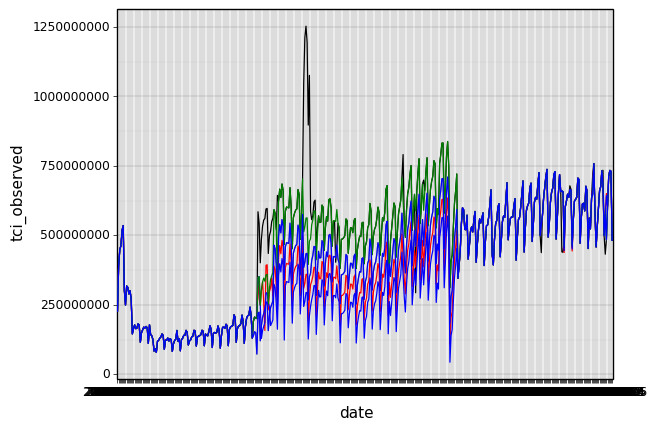

<ggplot: (8744469767909)>

In [68]:
import plotnine as p9
gg = (p9.ggplot(df_union[df_union.region_slug == 'country_mexico'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes(y = 'tci_cleaned'), color = 'gray')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_20X'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_4X'), color = 'blue')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_OFF'), color = 'green')
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

### Weekly

#### Several experiments

In [69]:
df_list = list()
for k in range(4):
    file = ['ls1', 'ls4', 'ls20', 'ls100'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_20X', '_ls_OFF'][k]
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_{file}.csv")
    df = df[['week', 'days_num', 'date_min', 'region_slug', 
             'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['week', 'days_num', 'region_slug', 'date_min', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
df_union.head(2)    

ls1
(5022, 8)
ls4
(5103, 8)
ls20
(5103, 8)
ls100
(5022, 8)
(5022, 14)


,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464


#### Final result

In [ ]:
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max.csv")

df_max = df_max[df_max.days_num == 7][['week', 'days_num', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 

In [ ]:
print(df_max.shape)
df_union = df_max 

#### Export daily data to csv

In [70]:
df_union.describe()


,week,days_num,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
count,5022.000000,5022.0,5.022000e+03,5022.000000,5.022000e+03,5022.000000,5.022000e+03,5022.000000,5.022000e+03,5022.000000,5.022000e+03,5022.000000
mean,31.500000,7.0,2.808269e+08,-35.003678,2.397817e+08,-43.047611,2.412821e+08,-41.333455,2.468428e+08,-37.686231,2.533330e+08,-37.470842
std,17.897312,0.0,1.048669e+09,42.862752,8.352010e+08,34.663852,8.251020e+08,35.169389,8.307900e+08,38.480692,8.541556e+08,38.762806
min,1.000000,7.0,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365
25%,16.000000,7.0,1.747244e+07,-64.953540,1.555442e+07,-66.633714,1.646002e+07,-66.024562,1.718335e+07,-65.097778,1.718548e+07,-65.103608
50%,31.500000,7.0,5.505224e+07,-37.746712,4.868916e+07,-47.531536,5.064559e+07,-45.132268,5.322601e+07,-39.482800,5.321429e+07,-39.559556
75%,47.000000,7.0,1.520999e+08,-14.442002,1.358721e+08,-24.963296,1.372952e+08,-21.813084,1.457770e+08,-17.109440,1.457770e+08,-16.820138
max,62.000000,7.0,1.931785e+10,486.853576,1.047593e+10,262.178733,1.047582e+10,262.209076,1.047582e+10,261.746328,1.047593e+10,261.766752


In [71]:
print(df_union.week.max())
print(df_union.date_min.max())
df_union.head()

62
2021-05-10


,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464
2,3,7,2020-03-23,aguascalientes,5471700,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925
3,4,7,2020-03-30,aguascalientes,4701122,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593
4,5,7,2020-04-06,aguascalientes,3838557,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443


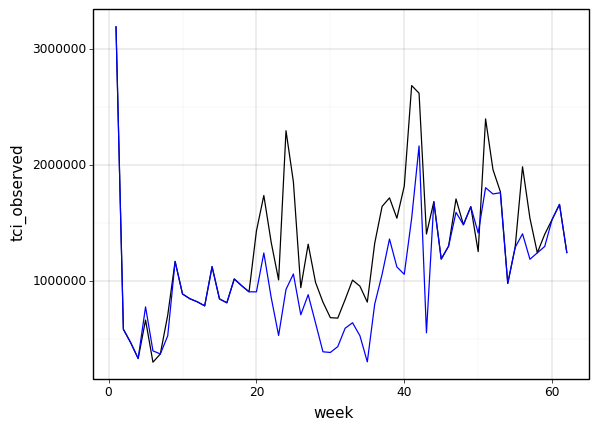

<ggplot: (8744458909661)>

In [72]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'kingston'],
                    p9.aes(x = 'week', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

In [73]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv", index=False)

In [74]:
df_union.head()

,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464
2,3,7,2020-03-23,aguascalientes,5471700,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925
3,4,7,2020-03-30,aguascalientes,4701122,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593
4,5,7,2020-04-06,aguascalientes,3838557,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443


In [75]:
df.region_slug.unique()[:5]

array(['aguascalientes', 'arequipa', 'barranquilla', 'belem',
       'belohorizonte'], dtype=object)

In [ ]:
#(df
# >> group_by('region_slug')
# >> summarize(min_tcp = _.tcp_clean.abs().min(),
#              max_tcp = _.tcp_clean.abs().max(), 
#              min_baseline = _.expected_2020.abs().min()/1e6,
#              max_baseline = _.expected_2020.abs().max()/1e6,
#              min_observed = _.observed.abs().min()/1e6,
#              max_observed = _.observed.abs().max()/1e6,
#              min_cleaned = _.S2_shift.abs().min()/1e6,
#              max_cleaned = _.S2_shift.abs().max()/1e6
#              )
# >> arrange(_.max_tcp)
#).tail(15)

#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [ ]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [ ]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

In [ ]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()